In [1]:
import random
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

In [2]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run in headless mode to avoid opening a browser window
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

In [3]:
def random_sleep():
    sleep_time = random.uniform(2, 5)  # Random delay between 2 and 5 seconds
    print(f"Sleeping for {round(sleep_time, 2)} seconds...")
    time.sleep(sleep_time)

In [5]:
def scrape_reviews(soup):
    # Find all review sections
    reviews = soup.find_all('section', {'class': lambda x: x and 'reviewContent' in x})
    # Extract relevant information from each review
    for review in reviews:
        try:
            # Extract the rating
            rating = review.find('div', {'data-service-review-rating': True})['data-service-review-rating']
        except AttributeError:
            rating = 'No rating'
        
        try:
            # Extract the title and review text
            review_title = review.find('h2', {'class': lambda x: x and 'heading' in x}).text.strip()
            review_text = review.find('p', {'class': lambda x: x and 'typography' in x}).text.strip()
        except AttributeError:
            review_title = 'No title'
            review_text = 'No text'
        
        try:
            # Extract and clean up the date
            review_date = review.find('p', {'class': lambda x: x and 'typography_body-m' in x}).text.strip()
            review_date = review_date.replace('Date of experience:', '').strip()
        except AttributeError:
            review_date = 'No date'

        # Print extracted information
        print(f"Rating: {rating}")
        print(f"Title: {review_title}")
        print(f"Review: {review_text}")
        print(f"Date: {review_date}")
        print("-" * 50)

        # Append extracted information to the list
        all_reviews.append({
            'Rating': rating,
            'Title': review_title,
            'Review': review_text,
            'Date': review_date
        })

In [6]:
base_url = "https://www.trustpilot.com/review/www.gap.com"
all_reviews = []


# Load the initial page
driver.get(base_url)
random_sleep()  # Add random sleep before starting

# Keep scraping while there's a next page
while True:
    # Parse the current page with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape reviews from the current page
    scrape_reviews(soup)

    try:
        # Find the "Next page" button using the class or name
        next_page_element = driver.find_element('xpath', "//a[@name='pagination-button-next']")

        # Get the href of the next page
        next_page_url = next_page_element.get_attribute('href')

        # If the URL is relative, construct the full URL
        if next_page_url.startswith('/'):
            next_page_url = "https://www.trustpilot.com" + next_page_url

        # Navigate to the next page
        print(f"Navigating to {next_page_url}")
        driver.get(next_page_url)
        random_sleep()  # Random sleep before loading the next page
    except Exception as e:
        print("No more pages to scrape. Exiting.")
        break  # Exit the loop when no next page is found

# Close the browser
driver.quit()

Sleeping for 3.81 seconds...
Rating: 1
Title: WARNING WARNING WARNING
Review: WARNING WARNING WARNING — DO NOT ORDER FROM GAP!!!09/09/24 Ordered 7 items "Your order #XXX has been received. Estimated Arrival 3-5 Business Days"09/12/24 - 6 items shipped via UPS and received 09/13/2409/10/24 - 1 item shipped via UPS ground (to USPS) 09/12/24 - USPS rec'd from UPS, delivery date 09/16. Delayed to 09/17. Delayed to 09/20. Delayed to 09/21. Delayed to 09/23. Now no date given at all! Per USPS tracking, pkg sent from NY to NJ to TX to GA to Knoxville, TN (3 hours from me), but today was shipped to COLUMBUS OHIO !?!?!?Have contacted Gap by chat FOUR TIMES, by phone TWO TIMES including to a US supervisor which I demanded after frustration with foreign chat/call centers. Repeated, useless apologies. Told by supervisor that they LITERALLY CANNOT FILE A LOST PACKAGE CLAIM unless carrier goes 48 hours without reporting the location --- and the USPS reports every single day that it is anywhere and e

In [10]:
import csv
with open('gap_reviews.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['Rating', 'Title', 'Review', 'Date'])
    writer.writeheader()
    writer.writerows(all_reviews)

print(f"Scraped {len(all_reviews)} reviews and saved to 'gap_reviews.csv'.")

Scraped 487 reviews and saved to 'gap_reviews.csv'.


In [6]:
import pandas as pd
import time
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Load the CSV file
csv_path = 'gap_reviews.csv'
df = pd.read_csv(csv_path)

# Define your Azure Text Analytics credentials
endpoint = "https://web-data-tirth.cognitiveservices.azure.com/"
key = "3d07f3e973684775aa1c84d581be5a3b"

# Authenticate the client
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
        endpoint=endpoint, 
        credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

# Function to analyze sentiment with rate limiting and retry mechanism
def sentiment_analysis_with_rate_limit(client, documents, batch_size=10, sleep_time=1):
    all_sentiments = []
    num_docs = len(documents)

    for i in range(0, num_docs, batch_size):
        batch = documents[i:i + batch_size]
        try:
            response = client.analyze_sentiment(documents=batch)
            for doc in response:
                if not doc.is_error:
                    all_sentiments.append({
                        'document': doc.id,
                        'sentiment': doc.sentiment,
                        'positive': doc.confidence_scores.positive,
                        'neutral': doc.confidence_scores.neutral,
                        'negative': doc.confidence_scores.negative
                    })
                else:
                    all_sentiments.append({
                        'document': doc.id,
                        'error': doc.error.message
                    })
        except HttpResponseError as e:
            if e.status_code == 429:  # Too many requests error
                print("Rate limit hit, waiting to retry...")
                time.sleep(sleep_time)  # Retry after sleep time
                response = client.analyze_sentiment(documents=batch)  # Retry
            else:
                print(f"Error occurred: {e}")
                break

        time.sleep(sleep_time)  # Sleep between each batch to avoid hitting rate limit

    return pd.DataFrame(all_sentiments)

# Assuming the CSV has a column 'Review'
reviews = df['Review'].tolist()
documents = [{"id": str(i), "language": "en", "text": review} for i, review in enumerate(reviews)]

# Perform sentiment analysis with rate limiting and batching
sentiment_df = sentiment_analysis_with_rate_limit(client, documents)

# Merge the results back with original data
df['Sentiment'] = sentiment_df['sentiment']

# Save the new dataframe to CSV
df.to_csv('gap_reviews_with_sentiment.csv', index=False)

In [7]:
df.head()

,Rating,Title,Review,Date,Sentiment
0,1,WARNING WARNING WARNING,WARNING WARNING WARNING — DO NOT ORDER FROM GA...,"September 22, 2024",negative
1,1,Carrier will leave your package anywhere,Order from them they used some other carrier n...,"September 24, 2024",negative
2,1,Absolutely terrible online service in…,Absolutely terrible online service in addition...,"August 13, 2024",negative
3,5,"GAP Bridgewater, NJ team is AWESOME","GAP Bridgewater, NJ team is AWESOME. They hel...","August 10, 2024",positive
4,1,terrible customer service,the customer service people at Gap couldn't sp...,"May 29, 2024",negative


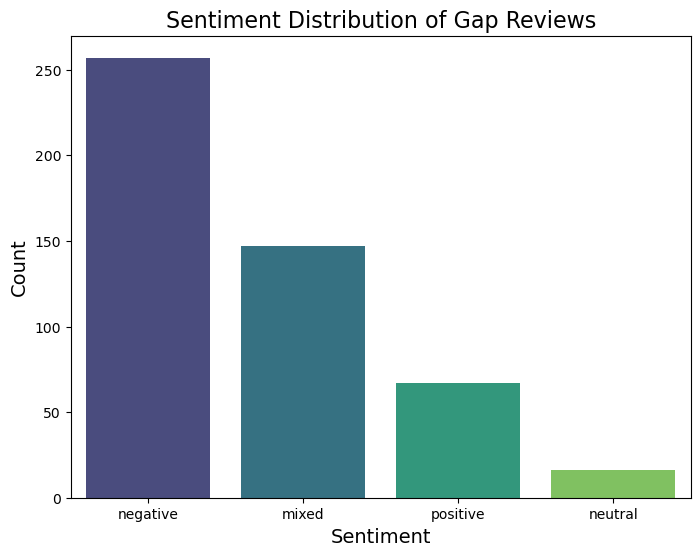

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of each sentiment type
sentiment_counts = df['Sentiment'].value_counts()

# Set up the figure size and plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Add labels and title
plt.title('Sentiment Distribution of Gap Reviews', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

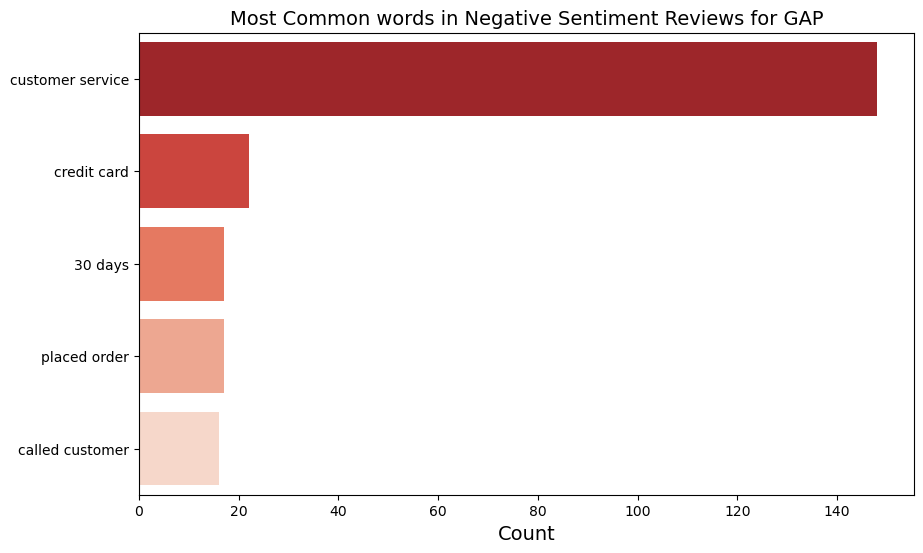

In [16]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

negative_reviews = df[df['Sentiment'] == 'negative']['Review']

# Function to clean and tokenize text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Tokenize text
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return tokens

# Create a list of all tokens from negative reviews
all_tokens = []
for review in negative_reviews:
    all_tokens.extend(clean_text(review))

# Create bigrams (2-word phrases)
bigrams = zip(all_tokens, all_tokens[1:])
bigram_phrases = [' '.join(bigram) for bigram in bigrams]

# Count the most common bigrams
bigram_counter = Counter(bigram_phrases)
common_bigrams = bigram_counter.most_common(5)  # Get top 10 most common bigrams

# Convert the results to a dataframe for visualization
common_bigrams_df = pd.DataFrame(common_bigrams, columns=['Bigram', 'Count'])

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette='Reds_r')

# Add labels and title
plt.title('Most Common words in Negative Sentiment Reviews for GAP', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.ylabel('', fontsize=14)

# Show the plot
plt.show()